## EDA Process

We start by thinking about our data and asking questions.

If there's a plan or even a chance you will build models with this data, be sure to split the dataset and only explore train. By exploring only train data, we keep from peeking at our out of sample data. If you are absolutely not going to model, it's OK to explore the entire dataset. Any exploration more in-depth than a histogram or .value_counts should only be done on train.

1. Hypothesize: Form and document your initial hypotheses about how the predictors (independent variables, features, or attributes) interact with the target (y-value or dependent variable). You can do this in the form of questions in a natural language (as opposed to "statistical" language).

2. Visualize: use visualization techniques to identify drivers. When a visualization needs to be followed up with a statistical test, do so.

3. Test your hypotheses when visualization isn't immediately clear. Use the appropriate statistical tests (t-tests, correlation, chi-square)

## General Recipe

1. Bivariate Stats. Bivariate means two variables.

    - Plot the interactions of each variable with the target. Document your takeaways.

        - For numeric to numeric, use a scatterplot or lineplot

        - For numeric to categorical variables, see https://seaborn.pydata.org/tutorial/categorical.html

    - Explore interation of independent variables using viz and/or hypothesis testing to address interdependence.

2. Multivariate Stats (more than 2 variables): Ask additional questions of the data, such as how subgroups compare to each-other and to the overall population. Answer questions using visualizations and/or hypothesis testing.

    - If you're using seaborn's relplot or catplot, use the hue or col arguments to add extra dimension(s) to the visuals.
      
    - Using sns.pairplot with hue may be helpful. With too many columns, however, it can produce visuals that are too noisy to be useful.
      
    - See https://seaborn.pydata.org/tutorial/axis_grids.html for more multivariate options
      
3. Statistical Tests: If the visualizations are not crystal clear, it's important to conduct hypothesis tests.

    - With numeric to numeric, test for correlation with Pearson's R for linear and Spearman's R for non-linear relationships.

    - For numeric to categorical, compare the means of two populations or a subgroup to the population using a t-test, if your samples are normaly(ish) distributed but have different variances (as determined by calling .var() on each column/Series, ANOVA to compare means from more than 2 groups, or a Mann-Whitney u-test if the data does not match the assumptions of a t-test.

    - With categorical to categorical variables, use χ2, chi-squared test.


## Standing Orders for Exploration

- **Document** your initial questions or assumptions. Write them down (in your README or notebook) so they are concrete and not in your head.

- **Document** your takeaways after each visualization. Even if your takeaway is, "there is nothing interesting between var1 and target".

- **Document** your answer to each question.

- When you run statistical tests to answer your questions, Document your null and alternative hypothesis, the test you run, the test results, and your conclusion.

- **Document** your takeaways, in case that wasn't clear. It is a huge component of your final deliverable/analysis.

- **Document** your action plan. What are your next steps and/or new questions based on what you have learned? I recommend documenting, continuing through all of your questions, and then going back and taking action only after you have answered your initial questions.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

from acquire import get_titanic_data

np.random.seed(123)

Found your sauce my bro
Found your sauce my bro
Found your sauce my bro


In [2]:
df = get_titanic_data()
df.head(2)


Found your sauce my bro


,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [3]:
df.isna().sum()

passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [4]:
# Useful helper for checking for nulls
# What proportion of each column is empty?
df.isna().mean()

passenger_id    0.000000
survived        0.000000
pclass          0.000000
sex             0.000000
age             0.198653
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.002245
class           0.000000
deck            0.772166
embark_town     0.002245
alone           0.000000
dtype: float64

In [5]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark'])

    df = pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1)

    df = df.drop(columns=['sex', 'embark_town']) 

    df = df.rename(columns={"sex_female": "is_female"})

    return df

In [6]:
df = prep_titanic(df)
df.head(2)

,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,3,22.0,1,0,7.2500,S,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,0,1,1,0,0


In [7]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [8]:
# Stratify with categorical target variables
train, validate, test = train_validate_test_split(df, target='survived')
train.shape, validate.shape, test.shape

((398, 12), (171, 12), (143, 12))

In [9]:
# Stratification means we'll get even proportions of the target variable in each data set
train.survived.mean(), validate.survived.mean(), test.survived.mean()

(0.4045226130653266, 0.40350877192982454, 0.40559440559440557)

In [10]:
train.head(2)

,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
450,0,2,36.0,1,2,27.75,S,0,0,0,0,1
543,1,2,32.0,1,0,26.00,S,0,0,0,0,1


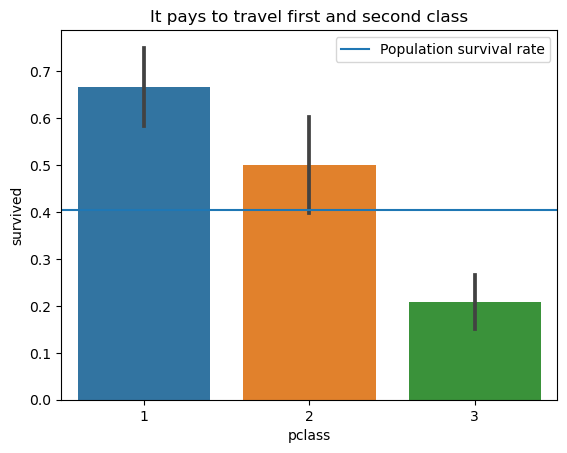

In [11]:
plt.title("It pays to travel first and second class")
sns.barplot(x="pclass", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [12]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "survival and class of ticket are independent"
alternative_hypothesis = "there is a relationship between class of ticket and survival"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.pclass)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that survival and class of ticket are independent
Sufficient evidence to move forward understanding that there is a relationship between class of ticket and survival


6.956716773744683e-15

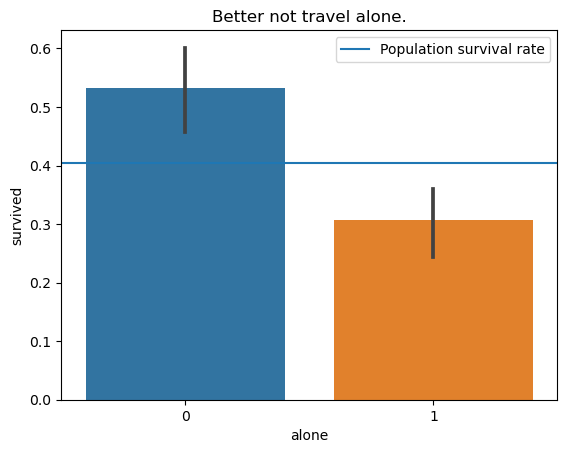

In [13]:
plt.title("Better not travel alone.")
sns.barplot(x="alone", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [14]:
# If the visual was unclear or we need more confirmation, run a hypothesis test
# Let's run a chi squared to compare proportions
alpha = 0.05
null_hypothesis = "survival and traveling alone are independent"
alternative_hypothesis = "there is a relationship between survival and traveling alone"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.alone)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that survival and traveling alone are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and traveling alone


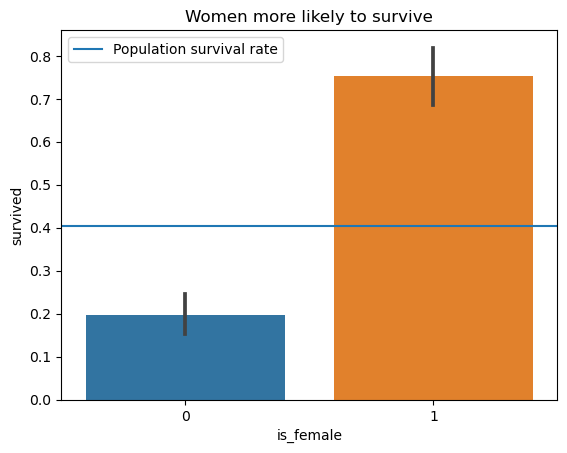

In [15]:
plt.title("Women more likely to survive")
sns.barplot(x="is_female", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [16]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05

null_hypothesis = "survival and gender are independent"
alternative_hypothesis = "there is a relationship between survival and gender"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.is_female)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that survival and gender are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and gender


4. What's the relationship between fare and survival?

Comparing Numeric vs. a Categorical Example

If the visual is not completely clear, the need for a hypothesis test increases.

First, set your confidence level and your alpha (Confidence level of 95% and alpha of 0.05 are good)
Select the appropriate test for your 2 variables:
If numeric to numeric, run a correlation test
Compare proportions with 
χ
2
Compare means with t-test or Mann-Whitney u-test.
Run tests, form conclusions, and document your results
(rinse and then repeat with other variables of interest)

1 tailed Mann-Whitney test. For more on Mann-Whitney, see the Wikipedia article

Write down your hypothesis setup

H
0
: Survived passenger fares cost less than or equal to non-surviving passenger fare

H
a
: Surviving passenger fares cost more than non-surviving passenger fares

In [17]:
# Subset the data into survived and not-surviving status
not_survived = train[train.survived == 0]
survived = train[train.survived == 1]

In [18]:
# check variances of the two groups
not_survived.fare.var(), survived.fare.var()

(846.4473286218973, 7299.474755819128)

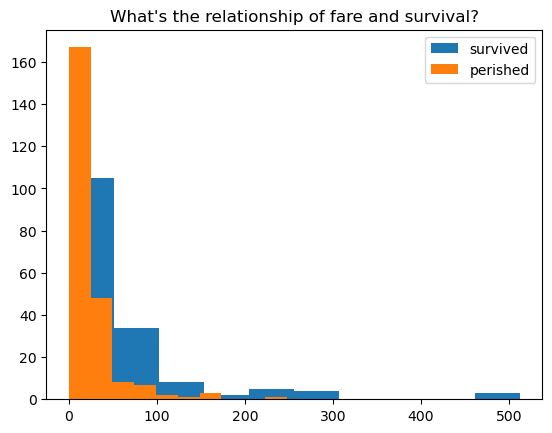

In [19]:
plt.title("What's the relationship of fare and survival?")
plt.hist(survived.fare, label="survived")
plt.hist(not_survived.fare, label="perished")
plt.legend()
plt.show()

In [20]:
from scipy import stats

null_hypothesis = "fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers"
alternative_hypothesis = "fares paid by surviving passengers are higher than non-surviving passengers"

# Use Mann Whitney u-test when t-test assumptions do not hold.
# The distributions are not normal and the variances are not equal, so we'll do mann-whitney
t, p = stats.mannwhitneyu(survived.fare, not_survived.fare, alternative="greater")

In [21]:
if p < alpha:
    print("We find evidence to reject the null hypothesis that", null_hypothesis)
    print("We find evidence evidence to move forward with the understaind that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("There is no evidence that", null_hypothesis)


We find evidence to reject the null hypothesis that fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers
We find evidence evidence to move forward with the understaind that fares paid by surviving passengers are higher than non-surviving passengers


In [22]:
p

4.665118844596931e-14

Takeaways

It pays to travel first and second class
Better to travel with family/company"
Women much more likely to survive
Survivors paid higher fares. This tracks with class of ticket.
Important Questions

What else can you determine by looking at sibsp, parch, fare, or age compared to our target survived
If the visuals are not crystal clear in indicating a relationship, then we should conduct hypothesis testing with the approviate variables along with the target.
For a second draft:
Any other variables we can combine together?
Would it make sense to create a variable like is_child which would be a boolean?
Would it make sense to investigate each independent variable with each-other and not only the target?
What else do you notice?
And what else can we learn if we look at the interaction of more than two variables at a time?


# Interaction of 3+ variables

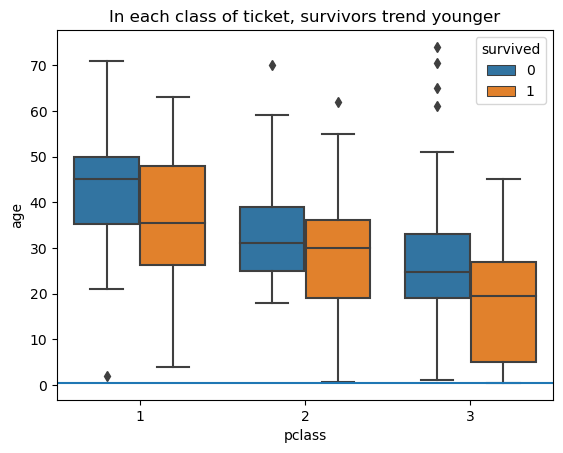

In [24]:
# At each class ticket, women have better survival rates
plt.title("In each class of ticket, survivors trend younger")
sns.boxplot(x="pclass", y="age", data=train, hue="survived")
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate)
plt.show()

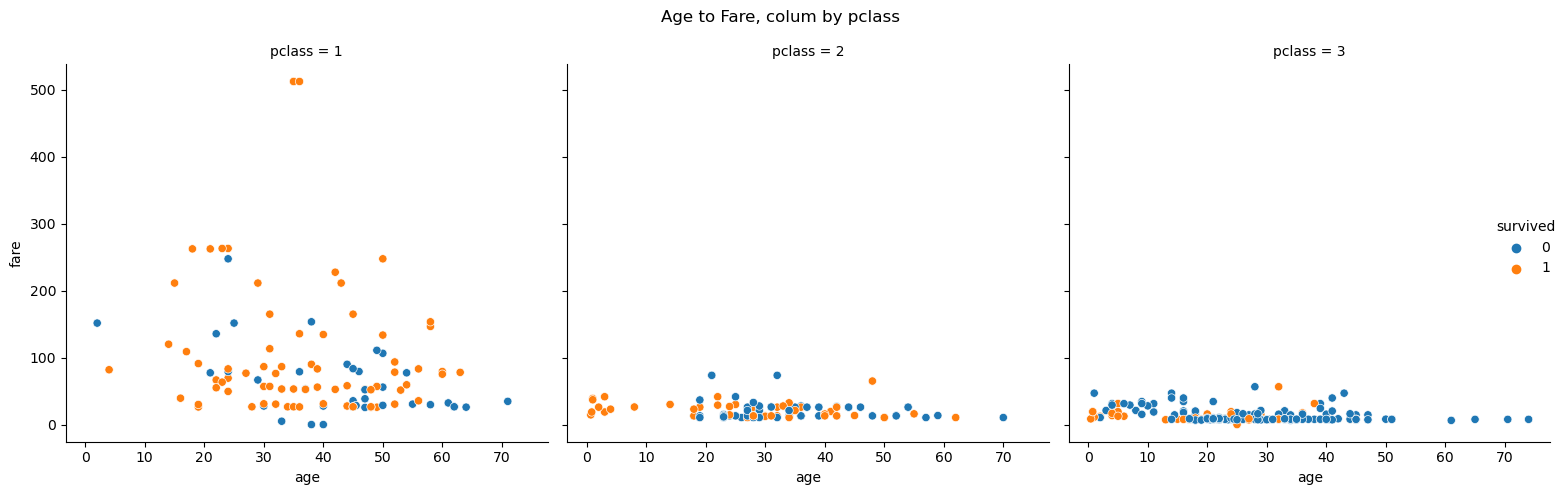

In [25]:
# No discernable relationship between age and fare, but the pclass relates to survival
rel = sns.relplot(x='age', y='fare', data=train, col="pclass", hue="survived")
rel.fig.suptitle('Age to Fare, colum by pclass') # One way to title a relplot
plt.tight_layout()

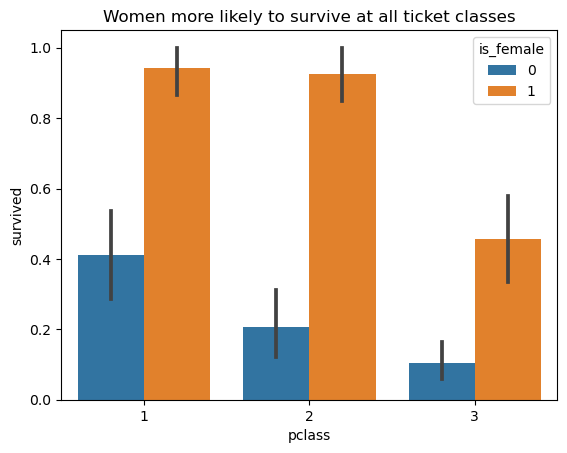

In [26]:
plt.title("Women more likely to survive at all ticket classes")
sns.barplot(x="pclass", y="survived", hue="is_female", data=train)
population_survival_rate = train.survived.mean()
plt.show()

In [27]:
women_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 1)]
men_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 0)]

print(f"Overall survival rate:", round(train.survived.mean(), 2))
print(f"Overall female survival rate", round(train[train.is_female == 1].survived.mean(), 2))
print(f"Overall male survival rate", round(train[train.is_female == 0].survived.mean(), 2))
print(f"3rd class ticket survival rate", round(train[train.pclass == 3].survived.mean(), 2))
print(f"Survival rate for women in 3rd class:", round(women_in_3rd_class.survived.mean(), 2))
print(f"Survival rate for men in 3rd class:", round(men_in_3rd_class.survived.mean(), 2))


Overall survival rate: 0.4
Overall female survival rate 0.75
Overall male survival rate 0.2
3rd class ticket survival rate 0.21
Survival rate for women in 3rd class: 0.46
Survival rate for men in 3rd class: 0.1


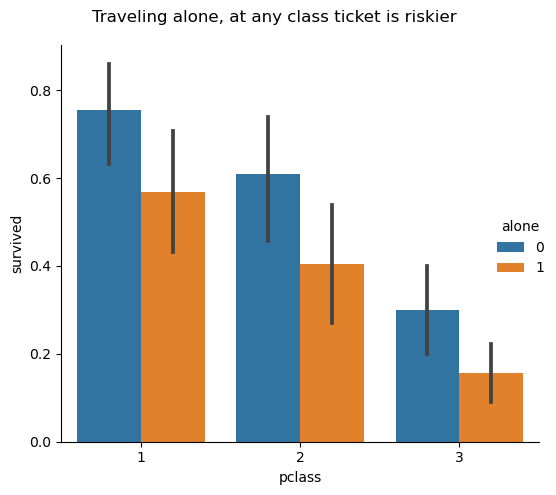

In [28]:
cat = sns.catplot(data=train, x="pclass", y="survived", hue="alone", kind="bar")
cat.fig.suptitle("Traveling alone, at any class ticket is riskier")
plt.tight_layout()

In [30]:
# Gender subset setup
male_subset = train[train.is_female == 0]
female_subset = train[train.is_female == 1]

In [31]:
null_hypothesis = "survival and pclass are independent for female passengers"
alternative_hypothesis = "survival and pclass are dependent for female passengers"

alpha = 0.05
observed = pd.crosstab(female_subset.survived, female_subset.pclass)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("Evidence suggests that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", alternative_hypothesis)


We reject the null hypothesis that survival and pclass are independent for female passengers
Evidence suggests that survival and pclass are dependent for female passengers


In [ ]:
null_hypothesis = "survival and pclass are independent for male passengers"
alternative_hypothesis = "survival and pclass are dependent for male passengers"

alpha = 0.05
observed = pd.crosstab(male_subset.survived, male_subset.pclass)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("Evidence suggests that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", alternative_hypothesis)
